# Graficador de resultados

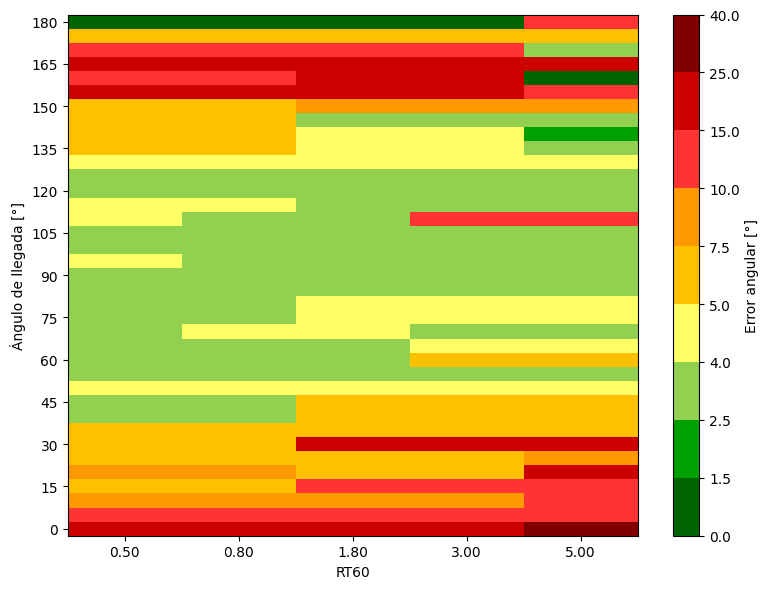

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import os
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap, BoundaryNorm

# === CONFIGURACIONES ===
measure = "sweep"         # Puede ser: "angle_error", "snr_db", etc.
method_graph = "phat"
x_variable = "rt60"           # Ej: "rt60_num", "snr_db", "dist_source"
x_lim = (0.5, 5.0)                # Limite eje x (solo para interpolated)
modo_grafico = "grid"     # "grid" o "interpolated"

# === ETIQUETAS DEL EJE X (con unidades) ===
x_labels = {
    "rt60_num": "RT60 [s]",
    "snr_db": "SNR [dB]",
    "dist_source": "DISTANCIA [m]",
    "angle": "ÁNGULO [°]"
}

# === PALETA DE COLORES PERSONALIZADA ===
boundaries = [0, 1.5, 2.5, 4, 5, 7.5, 10, 15, 25, 40]
colors = [
    "#006400", "#00a000", "#92d050", "#ffff66", "#ffc000",
    "#ff9900", "#ff3333", "#cc0000", "#800000"
]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, len(colors), clip=True)

# === MAPAS RT60 ===
rt60_map = {
    "very_short": "0.5 s", "short": "0.8 s", "medium": "1.8 s",
    "long": "3 s", "very_long": "5 s"
}
rt60_numeric = {v: float(v[:-2]) for v in rt60_map.values()}

# === CARGA DE DATOS ===
csv_folder = "csv_results"
pattern = os.path.join(csv_folder, "sweep_0_180_5_*.csv")
archivos = glob.glob(pattern)
if not archivos:
    raise FileNotFoundError("No se encontraron archivos")

dfs = []
for archivo in archivos:
    match = re.search(r"sweep_0_180_5_(.*?)_rev_(.*)\.csv", archivo)
    if match:
        reverb_key = match.group(1).lower()
        metodo = match.group(2).upper()
        rt60_val = rt60_map.get(reverb_key, "?")
        df_tmp = pd.read_csv(archivo)
        df_tmp["method"] = metodo
        df_tmp["rt60_val"] = rt60_val
        dfs.append(df_tmp)

df = pd.concat(dfs, ignore_index=True)
df["rt60_num"] = df["rt60_val"].map(rt60_numeric)
df = df[df["method"].str.lower() == method_graph.lower()]

# === VALIDAR VARIABLE X ===
if x_variable not in df.columns:
    raise ValueError(f"La columna '{x_variable}' no está en el DataFrame.")
if not np.issubdtype(df[x_variable].dtype, np.number):
    try:
        df[x_variable] = pd.to_numeric(df[x_variable])
    except Exception:
        raise TypeError(f"No se pudo convertir '{x_variable}' a tipo numérico.")

# === GRAFICADO ===
plt.figure(figsize=(8, 6))
x_label = x_labels.get(x_variable, x_variable.upper())

if modo_grafico == "interpolated":
    angle_vals = np.linspace(0, 180, 500)
    x_vals = np.linspace(x_lim[0], x_lim[1], 400)
    X, A = np.meshgrid(x_vals, angle_vals)

    points = df[["angle", x_variable]].values
    values = df["angle_error"].values
    Z = griddata(points, values, (A, X), method="linear")
    Z_masked = np.ma.masked_invalid(Z)

    heatmap = plt.contourf(
        X, A, Z_masked,
        levels=boundaries, cmap=cmap, norm=norm, extend="max"
    )

    plt.xlabel(x_label)
    plt.ylabel("Ángulo de llegada [°]")
    plt.xlim(x_lim)
    plt.gca().invert_yaxis()

elif modo_grafico == "grid":
    df["angle_round"] = df["angle"].round(1)
    df["x_round"] = df[x_variable].round(2)

    pivot = df.pivot_table(
        index="angle_round",
        columns="x_round",
        values="angle_error"
    ).sort_index(ascending=False)

    ny, nx = pivot.shape
    x = np.arange(nx + 1)
    y = np.arange(ny + 1)

    pc = plt.pcolormesh(x, y, pivot.values, cmap=cmap, norm=norm, shading="auto")

    xticks = np.arange(0.5, nx + 0.5)
    xlabels = [f"{val:.2f}" for val in pivot.columns]
    step = max(1, ny // 10)
    yticks = np.arange(0.5, ny + 0.5, step)
    ylabels = [f"{val:.0f}" for val in pivot.index[::step]]

    plt.xticks(ticks=xticks, labels=xlabels)
    plt.yticks(ticks=yticks, labels=ylabels)

    heatmap = pc

    plt.xlabel(x_label)
    plt.ylabel("Ángulo de llegada [°]")
    plt.gca().invert_yaxis()

else:
    raise ValueError("Modo gráfico no reconocido. Use 'grid' o 'interpolated'.")

# === BARRA DE COLOR Y GUARDADO ===
cbar = plt.colorbar(heatmap, ticks=boundaries)
cbar.set_label("Error angular [°]")

os.makedirs("figuras_heatmaps", exist_ok=True)
plt.tight_layout()
plt.savefig(f"figuras_heatmaps/{measure}_heatmap_{modo_grafico}_{method_graph}.png", dpi=300)
plt.show()
